# Country labelling
This notebook aims to provide an automatic method to label countries previously extract in the [Polygon extraction process](polygon_extraction.ipynb)   
## 1. To load the previously extracted polygons

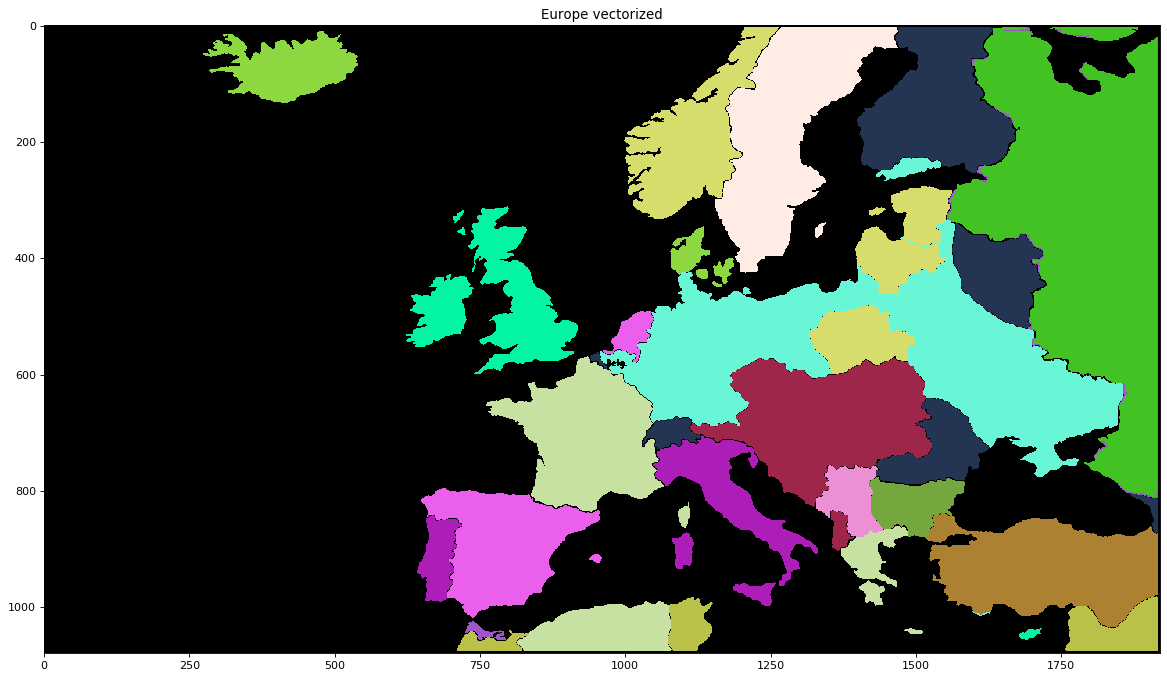

In [2]:
%matplotlib inline
import os
import shapely.wkt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import skimage.draw
import cv2

def load_polygons(folder):
    files = os.listdir(folder)
    res = {}
    for filename in files :
        path = os.path.join(folder, filename)
        with open(path, 'r') as wkt_file :
            polygon = shapely.wkt.loads(wkt_file.read()) 
        colour_code = filename.split('_')[0]
        try:
            res[colour_code]
        except KeyError:
            res[colour_code] = []
        res[colour_code].append(polygon)
    return [res[index] for index in res]

def disp_bounding_boxes(img, polygons, saveTo='') :
    todisp = img.copy()
    for polygon in polygons :
        (minx, miny, maxx, maxy) = np.array(polygon.bounds).astype(int)
        cv2.rectangle(todisp, (minx, miny), (maxx, maxy), (0, 0, int(np.max(todisp))), 2)
    display_img(todisp, '', True)
    if saveTo :
        plt.imsave(saveTo, todisp)

def draw_polygons(img, polygons, color):
    res = img.copy()
    for polygon in polygons :
        coords = np.array(polygon.exterior.coords)
        rr, cc = skimage.draw.polygon(coords[:, 1], coords[:, 0])
        res[rr, cc] = color
    return res

def display_img(img, title="", big=False) : 
    if big : 
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

polygons = load_polygons('tmp/wkt')

europe = plt.imread('input/europe_1918.png')[:, :, :3]
europe_vector = np.zeros(europe.shape).astype(int)
for i, countryset in tqdm(enumerate(polygons), total=len(polygons)):
    europe_vector = draw_polygons(europe_vector, countryset, np.random.choice(range(256), size=3))

display_img(europe_vector, 'Europe vectorized', True)

## 2. Text recognition with tesseract

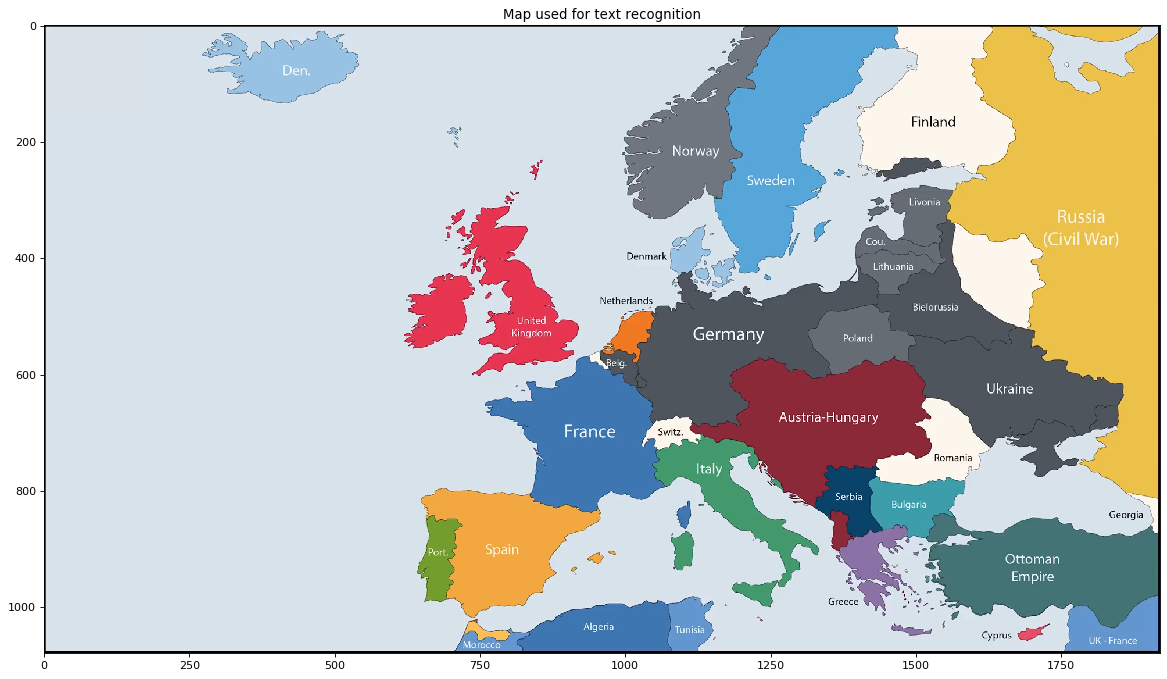

In [3]:
try :
    europe_cleaned = plt.imread('tmp/europe_cleaned.png')
except FileNotFoundError:
    print('Could not found tmp/europe_cleaned.png, try running Polygon extraction notebook to generate it')
display_img(europe_cleaned, 'Map used for text recognition', True)

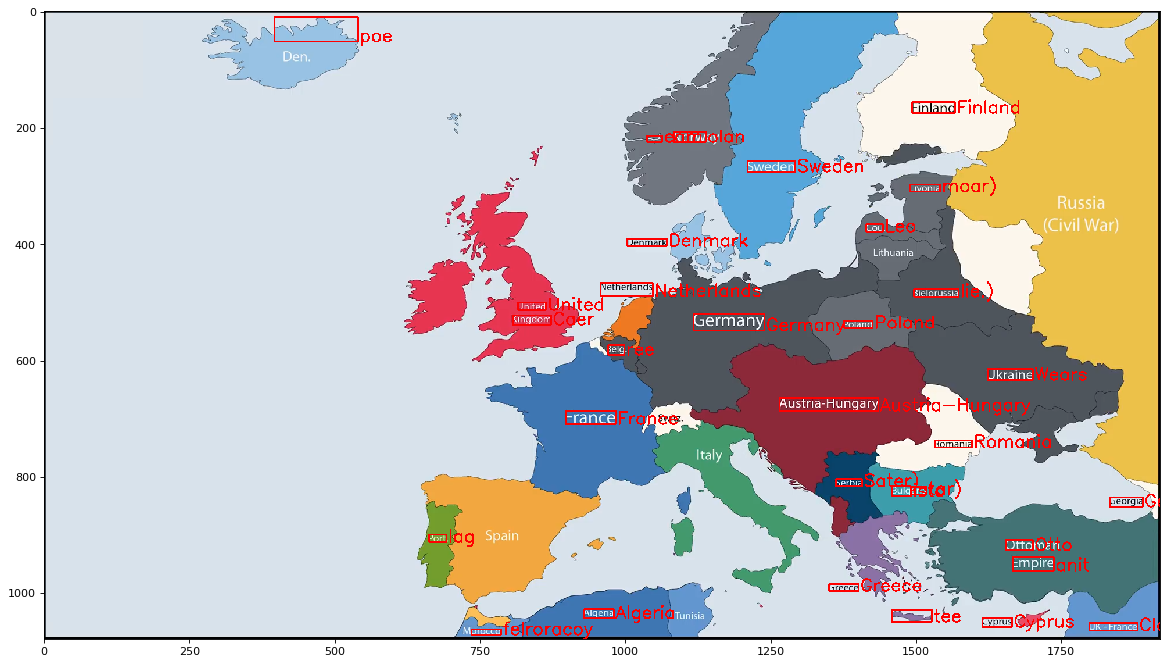

,index,bbox,text
0,5,"POLYGON ((540 10, 540 52, 396 52, 396 10, 540 ...",poe
1,13,"POLYGON ((1567 156, 1567 175, 1493 175, 1493 1...",Finland
2,21,"POLYGON ((1063 214, 1063 225, 1037 225, 1037 2...",eam
3,22,"POLYGON ((1138 207, 1138 225, 1083 225, 1083 2...",olan
4,32,"POLYGON ((1292 257, 1292 276, 1210 276, 1210 2...",Sweden
5,48,"POLYGON ((1541 298, 1541 310, 1490 310, 1490 2...",moar)
6,52,"POLYGON ((1443 366, 1443 379, 1414 379, 1414 3...",Leo
7,60,"POLYGON ((1071 391, 1071 404, 1003 404, 1003 3...",Denmark
8,75,"POLYGON ((1047 467, 1047 490, 957 490, 957 467...",Netherlands
9,79,"POLYGON ((1573 478, 1573 491, 1496 491, 1496 4...",Iie.)


In [7]:
import pytesseract
import pandas as pd
import skimage.color
from shapely.geometry import box
from pytesseract import Output
from pprint import pprint
def filter_recognition_results(df):
    significantLetters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
    authorizedLetters = significantLetters + "'-. ()"
    
    #At least 3 significant letters
    isLongEnough = lambda x : len([char for char in x if char in significantLetters]) >= 3
    noForbidden = lambda x : ''.join([char for char in x if char in authorizedLetters]) == x
    # Removing empty
    validity_array = [isLongEnough(row['text']) and noForbidden(row['text']) for _, row in df.iterrows()]
    return df[validity_array]
    
def apply_tesseract(img) :
    # Stores the images as black and white and color to perform analysis on both
    plt.imsave('tmp/tesseract_input_gray.png', skimage.color.rgb2gray(img), cmap='gray')
    d = pytesseract.image_to_data('tmp/tesseract_input_gray.png', config="--oem 3 --psm 11",lang='eng', output_type=Output.DICT)
    #plt.imsave('tmp/tesseract_input_color.png', img, cmap='gray')
    #d_color = pytesseract.image_to_data('tmp/tesseract_input_color.png', config="--oem 3 --psm 11",lang='eng', output_type=Output.DICT)
    #Now text and bounding boxes are extracted
    boxes = []
    bboxes = pd.DataFrame(columns=['bbox'])
    # Filtering unisgnificant results from text recognition (ex : @àé won't pass the filter  )
    df = filter_recognition_results(pd.DataFrame(d))
    #df = df.append(filter_recognition_results(pd.DataFrame(d_color)))
    #Building shapely bounding boxes
    for i, row in df.iterrows():
        (x, y, w, h) = (row['left'], row['top'], row['width'], row['height'])
        boxes.append(box(x, y, x+w, y+h))
        bboxes.loc[i] =  [box(x, y, x+w, y+h)]
    # Only returns text and shapely bbox
    return bboxes.join(df.text).reset_index()

def disp_ocr_results(img, ocr_results, saveTo='') :
    todisp = skimage.color.rgba2rgb(img)
    disp_color = (int(np.max(todisp)) , 0, 0)
    for i, row in ocr_results.iterrows():
        (minx, miny, maxx, maxy) = np.array(row['bbox'].bounds).astype(int)
        cv2.rectangle(todisp, (minx, miny), (maxx, maxy),disp_color , 2)
        cv2.putText(todisp,row['text'], (maxx+3,maxy), cv2.FONT_HERSHEY_SIMPLEX, 1, disp_color, 2)
    display_img(todisp, '', True)
    
    if saveTo :
        plt.imsave(saveTo, todisp)

countries_names = apply_tesseract(europe_cleaned )

disp_ocr_results(europe_cleaned, countries_names)

countries_names


## Linking countries' names with their polygons
Considering this rule : 
- The polygon Great Britain (which is pink here) is named if it contains text (Here : "United"). If several text boxes found, the biggest will be chosen (tallest = biggest on y coordinate)
- If a polygon does not have have a name inside (ex : Ireland), its name will be set to the name of the polygon of the same color (here : "United"). If several candidates, the biggest name rule will be applied


In [84]:
def display_polygon(polygon):
    (minx, miny, maxx, maxy) = np.array(polygon.bounds).astype(int)
    image = np.zeros((maxy+1, maxx+1))
    coords = np.array(polygon.exterior.coords)
    rr, cc = skimage.draw.polygon(coords[:, 1], coords[:, 0])
    image[rr, cc] = 1
    display_img(image[miny:, minx:])

def get_text_lying_in(text_data, polygon):
    row_lying_bool_array = [polygon.contains(row['bbox']) for _, row in text_data.iterrows()]
    return text_data[row_lying_bool_array]

def name_countries(polygons, countries_names) :
    res = []
    for countryset in tqdm(polygons):
        found_names = [None] * len(countryset)
        for i, land_shape in enumerate(countryset) :
            candidates = get_text_lying_in(countries_names, land_shape)
            if len(candidates) :
                font_sizes = []
                for _, candidate in candidates.iterrows() : 
                    (_, miny,_, maxy) = np.array(candidate['bbox'].bounds).astype(int)
                    font_sizes.append(maxy - miny)
                candidates['Font size'] = font_sizes
                best_match = candidates.loc[candidates['Font size'].idxmax()]
                found_names[i] = {'text' : best_match['text'], 'size' : best_match['Font size']}
        # The default name of unlabelled countries will be the biggest in found names
        max_size = max([match['size'] if match else 0 for match in found_names])
        if max_size== 0:
            dominant_name = None
        else :
            dominant_name = (next((found_name['text'] for found_name in found_names if found_name and found_name['size']==max_size)))
        # Now let's name all the polygons which could not be named at first
        for i, land_shape in enumerate(countryset):
            
            if found_names[i] :
                res.append({'name' : found_names[i]['text'], 'shape' : land_shape})
            else:
                res.append({'name' : dominant_name, 'shape' : land_shape})
    return res
countries_named = name_countries(polygons, countries_names)


/home/noan/miniconda3/envs/mapisto/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


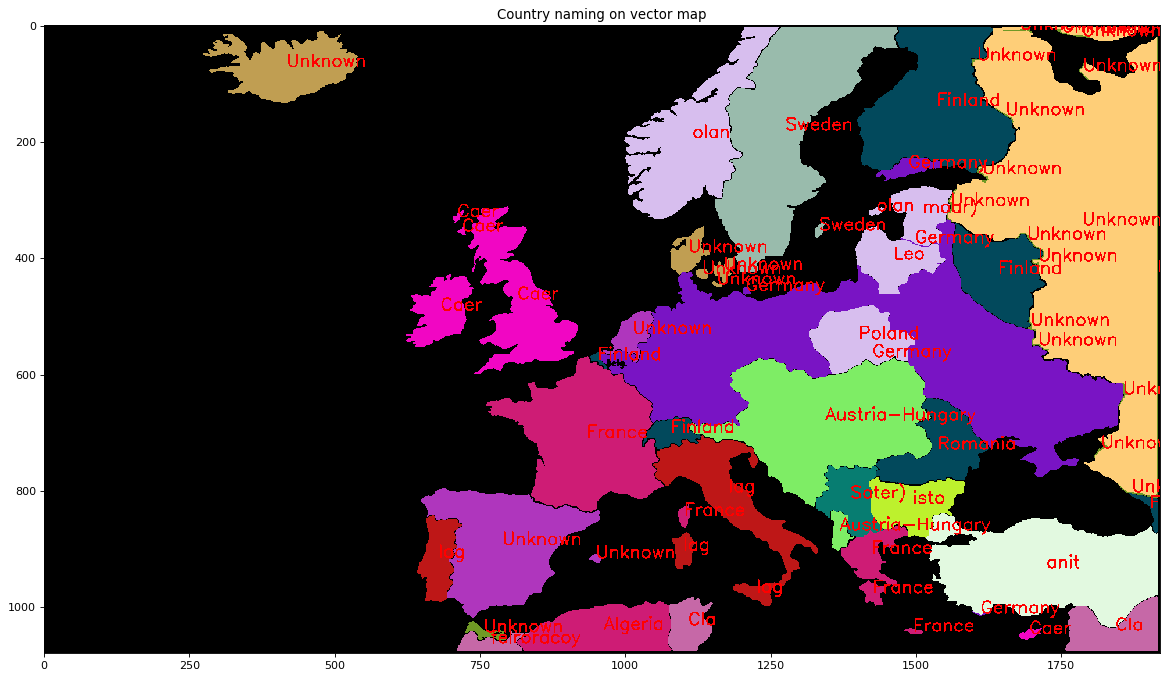

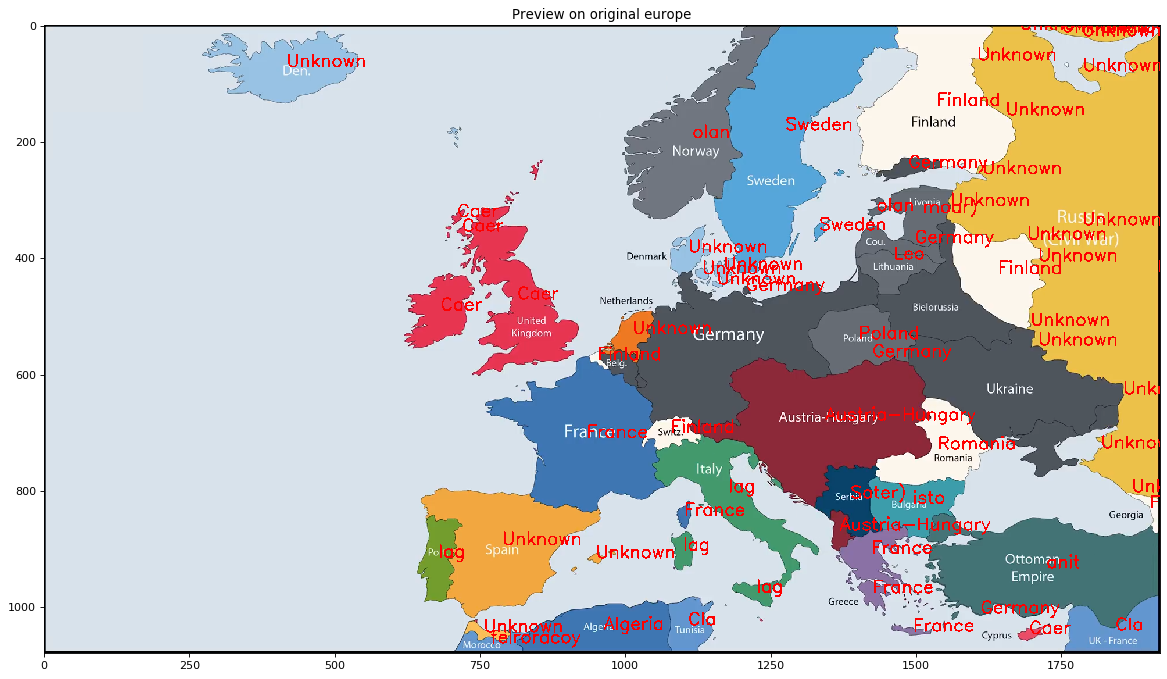

In [117]:
# Displaying the results
europe_with_names = skimage.color.rgba2rgb(europe_cleaned)
europe_vector_names = europe_vector/255
for country_named in countries_named:
    centroid = country_named['shape'].centroid
    cv2.putText(europe_with_names,
                country_named['name'] or 'Unknown', 
                (int(centroid.x),int(centroid.y)), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                1, 
                (int(np.max(europe_with_names)), 0, 0), 
                2)
    cv2.putText(europe_vector_names,
                country_named['name'] or 'Unknown', 
                (int(centroid.x),int(centroid.y)), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                1, 
                (round(np.max(europe_vector_names)), 0, 0), 
                2)
    
display_img(europe_vector_names, 'Country naming on vector map', True)
display_img(europe_with_names, 'Preview on original europe', True)
plt.imsave('output/europe_labelled.png', europe_with_names)

The result is very imprecise. A correction mechanism will be integrated on the website.
## 3. Result's storage

In [116]:
import os, shutil
output_dir = 'output/country_naming/'
try :
    shutil.rmtree(output_dir)
except FileNotFoundError:
    pass
os.makedirs(output_dir)
for i, country_data in enumerate(countries_named):
    output_file = os.path.join(output_dir, str(i))
    with open(output_file+'.wkt', 'w') as file:
        file.write(shapely.wkt.dumps(country_data['shape']))
    if country_data['name']:
        with open(output_file+'.txt', 'w') as file:
            file.write(country_data['name'])

print('DONE')

DONE
